In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict

### what is done:
construct Wikispeedia graph
run page rank
process the 'finished paths': 
    <br> - take into account back clicks to consider only the effective path
    <br> - 'processed_paths' contains all the finished paths starting from the 'hub' (the page with highest page rank in that path)


#### see next step at the bottom

##### please update this cell to keep track of prject progress

In [3]:
links = pd.read_csv("wikispeedia_paths-and-graph/links.tsv", sep='\t', skiprows = 11, names = ['link_source', 'link_target'])
# links.tsv contains all links between articles. It can be used to contruct a graph

In [4]:
#verify that there is no missing source/target
links.any().isna()

link_source    False
link_target    False
dtype: bool

In [5]:
G = nx.from_pandas_edgelist(links, 'link_source', 'link_target', create_using=nx.DiGraph())

In [6]:
dangling_nodes = []
for node, out_deg in G.out_degree():
    if out_deg == 0:
        dangling_nodes.append(node)
        
dangling_nodes

['Osteomalacia',
 'Local_community',
 'Directdebit',
 'Duchenne_muscular_dystrophy',
 'Klinefelter%27s_syndrome']

In [7]:
page_rank = nx.pagerank(G, alpha = 0.95)

In [8]:
keys = list(page_rank.keys())
vals = list(page_rank.values())
sorted_page_rank = {keys[i]: vals[i] for i in np.argsort(vals)[::-1]}

In [9]:
#At this step page rank is done for each page
# now we would like to consider the paths (FINISHED PATHS FOR NOW) and consider only the pages visited after the 'hub'

In [10]:
finished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress','timestamp','durationInSec','path','rating'])
unfinished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress' ,  'timestamp' ,  'durationInSec' ,  'path' ,  'target'   ,'type'])

In [11]:
finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN


In [12]:
unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [13]:

#final version of remove_unvisited_pages
# working well enfiiin

def remove_unvisited_pages(path):
    if path.count('<') == 0:
        return path
    
    i=0
    while i<len(path):

        if path[i] == '<':
        
            counter = 0
            tmp_i = i

            while tmp_i<len(path) and path[tmp_i] == '<':
       
                tmp_i +=1
                counter+=1
            v=max(0,i-counter)

            for j in range(v, i):

                path[j] = '<'
            i = tmp_i
        else:
            i+=1
    indx = np.where(np.array(path)=='<')[0]
    path = np.delete(np.array(path), indx)
    return path

In [14]:
#test remove_unvisited_pages
l =(finished_paths['path'].iloc[40]).split(';')
print(l)           
l=remove_unvisited_pages(l)
l

['14th_century', 'Europe', '<', 'England', '<', 'Christianity', 'Anglicanism', 'United_States', 'Walt_Whitman', '<', 'Poetry_of_the_United_States', '<', '<', '<', 'French_Revolution', 'Age_of_Enlightenment', 'David_Hume', 'Philosophy', 'Fyodor_Dostoevsky', '<', '<', '<', '<', 'Constitutional_monarchy', 'Government', 'Anarchism', 'Henry_David_Thoreau']


array(['14th_century', 'Christianity', 'Anglicanism', 'United_States',
       'French_Revolution', 'Constitutional_monarchy', 'Government',
       'Anarchism', 'Henry_David_Thoreau'], dtype='<U23')

In [40]:
processed_finished_paths = []
pages_with_no_rank_finished_paths = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
def process_paths(paths,processed_paths,pages_with_no_rank) :
    for i, s in paths.iterrows():
        path_split=(paths['path'].iloc[i]).split(';')
        path_split = remove_unvisited_pages(path_split)
        ranks = []
        for elem in path_split:
            r = page_rank.get(elem, -1)
            if r==-1:
                pages_with_no_rank.append(elem)
            ranks.append(r)

        processed_paths.append(path_split[:np.argmax(ranks)])


In [41]:
#processed paths contains all the paths starting from the 'hub' (selected as the page with highest page rank in that path)

In [42]:
processed_finished_paths = []
pages_with_no_rank_finished_paths = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(finished_paths,processed_finished_paths,pages_with_no_rank_finished_paths)  
processed_finished_paths

[['14th_century'],
 ['14th_century', 'Niger', 'Nigeria', 'British_Empire', 'Slavery'],
 ['14th_century', 'Renaissance', 'Ancient_Greece'],
 ['14th_century'],
 ['14th_century', 'Europe', 'North_America'],
 ['14th_century'],
 ['14th_century', 'Time', 'Isaac_Newton', 'Light'],
 ['14th_century', 'Time'],
 ['14th_century', '15th_century', 'Plato', 'Nature', 'Ultraviolet'],
 array(['14th_century', 'Time'], dtype='<U20'),
 ['14th_century'],
 ['14th_century', 'Time', 'Astronomy'],
 array(['14th_century', 'Renaissance', 'Empiricism', 'Nature', 'Weather'],
       dtype='<U12'),
 array(['14th_century', 'Renaissance', 'Leonardo_da_Vinci'], dtype='<U17'),
 ['14th_century', 'Renaissance', 'Leonardo_da_Vinci'],
 array(['14th_century', 'Time'], dtype='<U14'),
 ['14th_century',
  'English_peasants%27_revolt_of_1381',
  'Archbishop_of_Canterbury'],
 ['14th_century'],
 array(['14th_century', 'Time', 'Day', 'Sun', 'Sunlight', 'Ultraviolet'],
       dtype='<U12'),
 ['14th_century'],
 ['14th_century'],
 ['1

In [43]:
processed_unfinished_paths = []
pages_with_no_rank_unfinished_paths = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(unfinished_paths,processed_unfinished_paths,pages_with_no_rank_unfinished_paths)  
processed_unfinished_paths

[[],
 [],
 ['Malawi'],
 [],
 ['Paraguay'],
 ['Agriculture', 'History_of_the_world'],
 ['Mind', 'Christianity'],
 ['4-2-0'],
 [],
 ['Logic', 'Computer_science'],
 ['Battle_of_Gettysburg',
  'Washington%2C_D.C.',
  'United_Kingdom',
  'English_language'],
 [],
 ['Saint_Kitts_and_Nevis', 'United_Kingdom', 'World_War_II'],
 ['Ape'],
 ['Symmetry', 'Science', 'Age_of_Enlightenment', 'Dark_Ages'],
 [],
 ['Tasmanian_Devil', 'Dog', 'Postage_stamp'],
 ['Flute', 'Slovenia', 'NATO'],
 ['Bean', 'Peanut'],
 ['Tim_Berners-Lee', 'England', 'Atlantic_Ocean'],
 [],
 array([], dtype='<U6'),
 [],
 array(['Ape'], dtype='<U16'),
 array(['The_Shawshank_Redemption'], dtype='<U24'),
 [],
 array(['Second_Congo_War', 'World_War_II'], dtype='<U16'),
 [],
 ['Velociraptor'],
 [],
 [],
 [],
 array(['Aircraft', 'Hydrogen'], dtype='<U9'),
 ['Three_Laws_of_Robotics', 'Religion'],
 ['Semiconductor', 'Computer'],
 ['Edward_Jenner'],
 [],
 [],
 ['The_Legend_of_Zelda_series'],
 ['California'],
 ['Elias_Ashmole', 'Astrology

### Next Step
use the dataframe categories to replace each page in processed paths by each category and construct the graph using categories

In [44]:
categories = pd.read_csv("wikispeedia_paths-and-graph/categories.tsv", sep='\t', skiprows = 12, names=['article', 'category'])

In [45]:
categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [46]:
# the number of periods is the specifity of the category, the more specific 
# the more relevant 
def count_periods(s):
    return s.count('.')

In [47]:
# Add a column with the count of periods in the category
categories['period_count'] = categories['category'].apply(count_periods)

# Selecting the most specific category for each article
most_specific_category = categories.sort_values(by='period_count', ascending=False).drop_duplicates('article')

# Dropping the period_count column to get the final result
specific_categories = most_specific_category.drop(columns=['period_count'])

# Resetting the index for cleanliness
specific_categories.reset_index(drop=True, inplace=True)

specific_categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,European_Greenfinch,subject.Science.Biology.Birds
2,Rutherfordium,subject.Science.Chemistry.Chemical_elements
3,Eurasian_Oystercatcher,subject.Science.Biology.Birds
4,Eurasian_Jay,subject.Science.Biology.Birds


In [48]:
# making the article column the index
specific_categories = specific_categories.set_index('article')

In [49]:
specific_categories.head()

,category
article,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
European_Greenfinch,subject.Science.Biology.Birds
Rutherfordium,subject.Science.Chemistry.Chemical_elements
Eurasian_Oystercatcher,subject.Science.Biology.Birds
Eurasian_Jay,subject.Science.Biology.Birds


In [50]:
# transforming the article paths into paths of categories  
processed_finished_paths_serie = pd.Series(processed_finished_paths)
category_finished_paths = processed_finished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])

processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths)
category_unfinished_paths = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])

In [51]:
category_finished_paths.head()

0                    [subject.History.General_history]
1    [subject.History.General_history, subject.Geog...
2    [subject.History.General_history, subject.Hist...
3                    [subject.History.General_history]
4    [subject.History.General_history, subject.Geog...
dtype: object

In [52]:
category_unfinished_paths.head()

0                                                   []
1                                                   []
2    [subject.Geography.African_Geography.African_C...
3                                                   []
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [53]:
from collections import defaultdict

# building the connection dataframe with the counter
def build_category_connections(category_paths) :
    category_pairs_counter = defaultdict(int)

    # Process each path
    for path in category_paths:
        for i in range(len(path) - 1):
            # Increment the counter for each found pair
            pair = (path[i], path[i + 1])
            category_pairs_counter[pair] += 1

    # unique category list that appear in our paths, 
    # no need for all categories of articles in  

    unique_categories = list(set(cat for path in category_paths for cat in path))

    # Initialize an the connections
    category_connections = pd.DataFrame(index=unique_categories, columns=unique_categories).fillna(0)

    # filling up the values with the counts
    for (cat1, cat2), count in category_pairs_counter.items():
        category_connections.loc[cat1, cat2] = count
    
    return category_connections

In [54]:
category_connections_finished_paths = build_category_connections(category_finished_paths)
category_connections_finished_paths

,subject.History.Recent_History,subject.Religion.Myths,subject.Everyday_life.Drink,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Language_and_literature.Poetry_and_Opera,subject.Science.Physics.General_Physics,subject.Geography.Climate_and_the_Weather,subject.Everyday_life.Films,subject.IT.Software,subject.Geography.Mineralogy,...,subject.Geography.Geography_of_Great_Britain,subject.Geography.African_Geography.African_Countries,subject.Design_and_Technology.Railway_transport,subject.Science.Biology.Health_and_medicine,subject.History.North_American_History,subject.People.Producers_directors_and_media_figures,subject.History.British_History.British_History_Post_1900,subject.Everyday_life.Food_and_agriculture,subject.History.Historians_chroniclers_and_history_books,subject.Science.Biology.Plants
subject.History.Recent_History,30,0,0,2,0,2,0,1,0,1,...,4,3,5,3,0,0,5,3,0,0
subject.Religion.Myths,0,52,1,0,1,0,2,1,0,0,...,14,0,0,0,0,0,0,1,1,0
subject.Everyday_life.Drink,0,0,18,1,0,0,18,0,0,0,...,6,10,0,5,0,0,1,29,0,28
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,0,0,6,68,1,3,1,0,0,0,...,5,9,0,4,0,0,5,16,0,9
subject.Language_and_literature.Poetry_and_Opera,0,0,0,0,18,0,0,1,0,0,...,8,0,0,2,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Producers_directors_and_media_figures,0,1,0,0,0,0,0,6,0,0,...,4,0,0,11,0,0,3,0,0,0
subject.History.British_History.British_History_Post_1900,5,0,0,4,0,0,0,0,0,0,...,17,1,1,3,0,0,10,0,0,0
subject.Everyday_life.Food_and_agriculture,0,1,21,9,0,10,22,0,0,0,...,10,9,0,35,0,0,0,134,0,88
subject.History.Historians_chroniclers_and_history_books,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [55]:
category_connections_unfinished_paths = build_category_connections(category_unfinished_paths)
category_connections_unfinished_paths

,subject.History.Recent_History,subject.Religion.Myths,subject.Everyday_life.Drink,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Language_and_literature.Poetry_and_Opera,subject.Science.Physics.General_Physics,subject.Geography.Climate_and_the_Weather,subject.Everyday_life.Films,subject.IT.Software,subject.Geography.Mineralogy,...,subject.Geography.Geography_of_Great_Britain,subject.Geography.African_Geography.African_Countries,subject.Design_and_Technology.Railway_transport,subject.Science.Biology.Health_and_medicine,subject.History.North_American_History,subject.People.Producers_directors_and_media_figures,subject.History.British_History.British_History_Post_1900,subject.Everyday_life.Food_and_agriculture,subject.History.Historians_chroniclers_and_history_books,subject.Science.Biology.Plants
subject.History.Recent_History,12,0,0,0,0,0,0,0,0,1,...,1,1,1,1,0,0,1,1,0,0
subject.Religion.Myths,0,9,0,0,0,0,2,6,0,0,...,4,0,0,0,0,0,0,0,0,0
subject.Everyday_life.Drink,0,0,4,0,0,0,7,0,0,0,...,2,2,0,4,0,0,1,13,0,9
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,0,0,1,25,0,0,0,0,0,0,...,0,2,0,0,0,0,5,5,0,4
subject.Language_and_literature.Poetry_and_Opera,0,0,0,0,13,0,0,0,0,0,...,4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Producers_directors_and_media_figures,0,0,0,0,0,0,0,0,0,0,...,3,0,0,1,0,0,0,0,0,0
subject.History.British_History.British_History_Post_1900,2,0,0,2,0,1,0,0,0,0,...,11,0,0,1,0,0,7,0,0,0
subject.Everyday_life.Food_and_agriculture,0,0,9,3,0,1,8,0,0,4,...,6,1,0,10,0,0,0,71,0,51
subject.History.Historians_chroniclers_and_history_books,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [56]:
def count_words(index):
    return len(index.split('.'))

In [57]:
def count_words(index):
    return len(index.split('.'))

In [58]:
import seaborn as sns
def heatmap_general_categories(category_connections) :
    df = category_connections.copy() 
    #Remove 'subject.' prefix
    df.index = df.index.str.replace('subject.', '')
    df.columns = df.columns.str.replace('subject.', '')
    # Sort the dataframe based on the number of words in ascending order
    df['WordCount'] = df.index.map(count_words)
    df_sorted = df.sort_values(by='WordCount', ascending = False)
    df_sorted = df_sorted.drop(columns='WordCount')
    index_order = df_sorted.index.tolist()

    # Reorder the columns based on the order of the index
    df_sorted = df_sorted.reindex(columns=index_order)

    #regroup all columns that have a common prefix, to  keep only general categories
    for ind1,row1 in df_sorted.iterrows() :
        for ind2,row2 in df_sorted.iterrows() :
            if ind1.split('.')[0] == ind2.split('.')[0] :
                for ind3,row3 in df_sorted.iterrows() :
                    df_sorted.loc[ind3,ind1] += df_sorted.loc[ind3,ind2]
                    df_sorted.loc[ind1,ind3]+= df_sorted.loc[ind2,ind3]
                break
    iter1=0         
    for ind1,row1 in df_sorted.iterrows() :
            iter2=0
            for ind2,row2 in df_sorted.iterrows():
                if ind1!=ind2 and ind1.split('.')[0] == ind2.split('.')[0] and iter2<iter1 :
                    df_sorted = df_sorted.drop(columns = ind1)
                    df_sorted= df_sorted.drop(index=ind1)
                    break
                iter2+=1
            iter1+=1
        
        

    new_index = df_sorted.index.str.split('.').str.get(0)

    # Replace the index with the new_index
    df_sorted.index = new_index

    new_columns = df_sorted.columns.str.split('.').str.get(0)

    # Replace the columns with the new_columns
    df_sorted.columns = new_columns
    df = df_sorted.reindex(df.index, axis=1)
    df = df_sorted.drop(columns="Unknown_Category")
    df = df.drop(index = "Unknown_Category")
    np.fill_diagonal(df.values, 0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True)

    plt.title('Heatmap of Weights between Categories')
    plt.show()    
    

C:\Users\rac\AppData\Local\Temp\ipykernel_7724\3938921778.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace('subject.', '')
C:\Users\rac\AppData\Local\Temp\ipykernel_7724\3938921778.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('subject.', '')


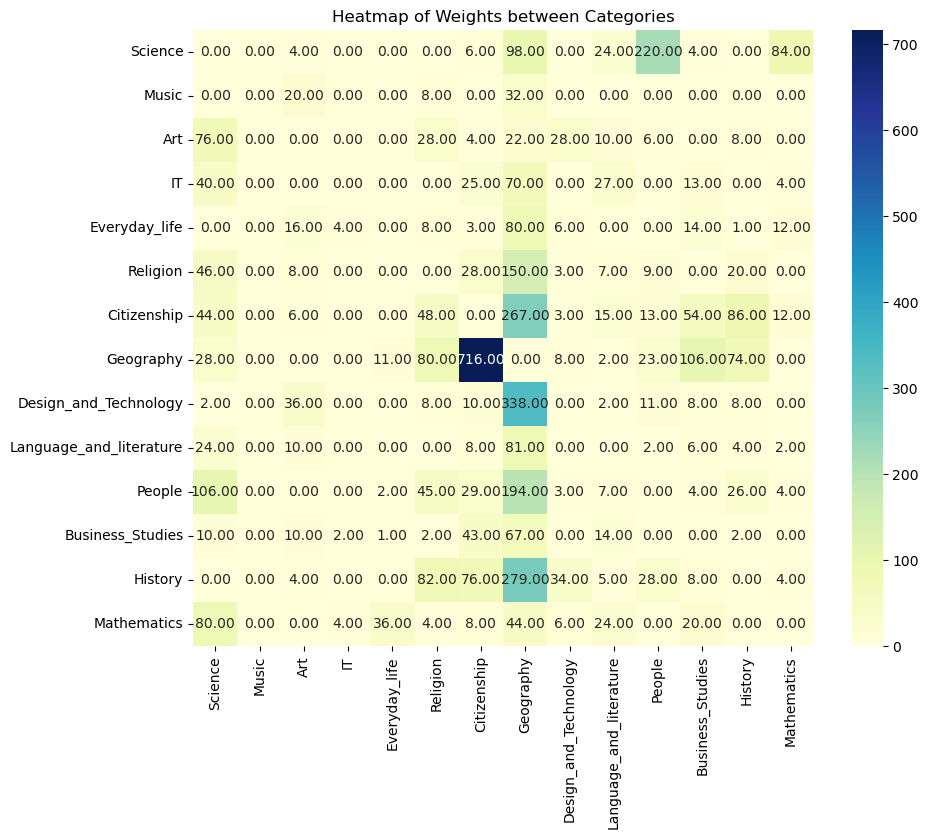

In [59]:
heatmap_general_categories(category_connections_finished_paths)

C:\Users\rac\AppData\Local\Temp\ipykernel_7724\3938921778.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace('subject.', '')
C:\Users\rac\AppData\Local\Temp\ipykernel_7724\3938921778.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('subject.', '')


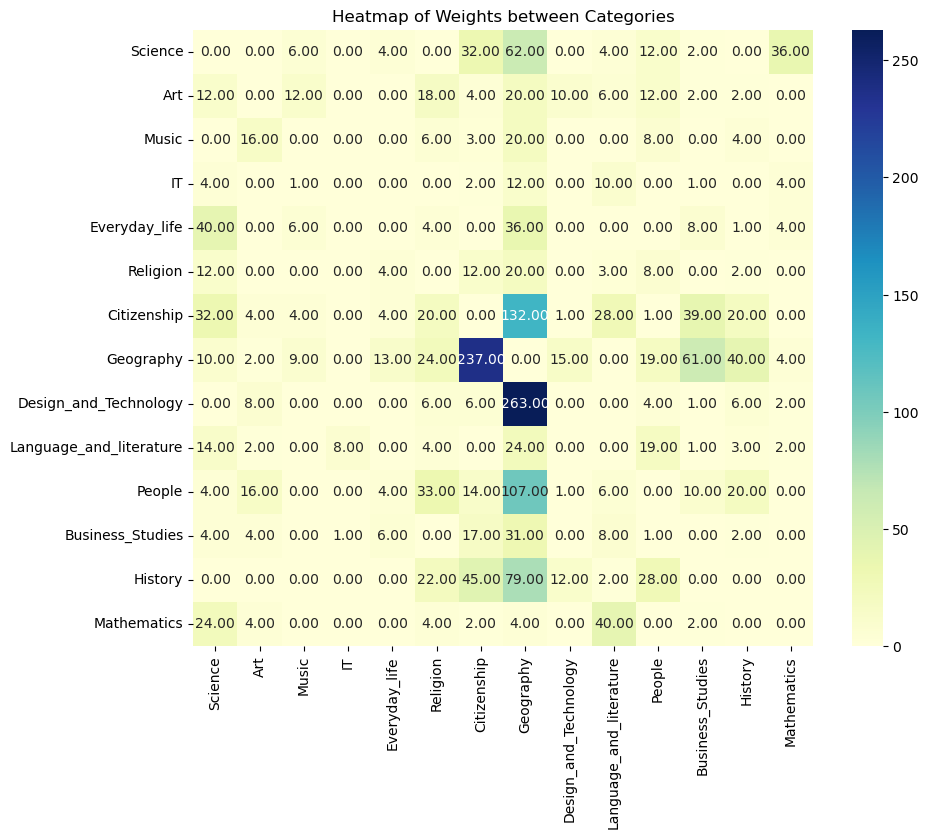

In [60]:
heatmap_general_categories(category_connections_unfinished_paths)

C:\Users\rac\AppData\Local\Temp\ipykernel_7724\2196353530.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace('subject.', '')
C:\Users\rac\AppData\Local\Temp\ipykernel_7724\2196353530.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('subject.', '')


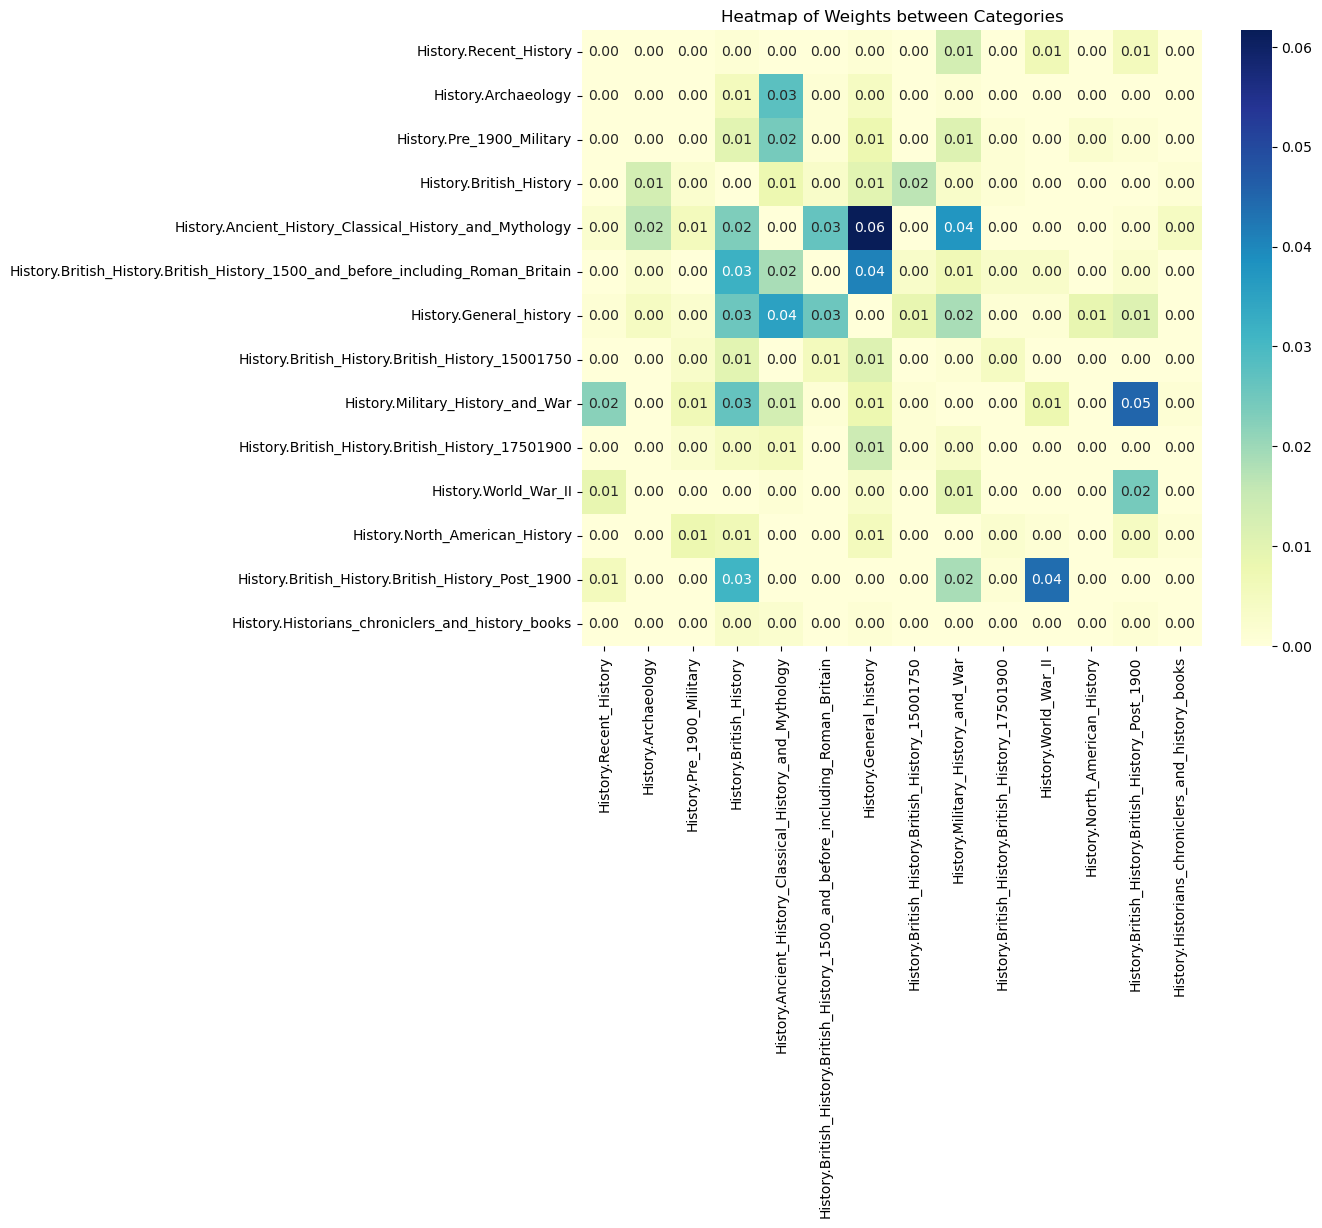

In [61]:
#Now we can also focus only on only categories of science 

def heatMap_Special_Category(category,category_connections) : 
    df = category_connections.copy() 
    #Remove 'subject.' prefix
    df.index = df.index.str.replace('subject.', '')
    df.columns = df.columns.str.replace('subject.', '')
    df = df.filter(like='History.', axis=1).filter(like='History.', axis=0)
    np.fill_diagonal(df.values, 0)
    df = df.div(df.sum().sum())
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True)

    plt.title('Heatmap of Weights between Categories')
    plt.show()   
heatMap_Special_Category("",category_connections_finished_paths)
